## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
from somperf.metrics import *
from somperf.utils.topology import rectangular_topology_dist

import optuna
import numpy as np

d:\Kuliah\JST\Neural-Network-Final-Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_excel('dataset.xlsx', sheet_name='Sheet1') 
data = df.iloc[:,:-1]

## Preprocessing

In [3]:
scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(data.copy())
df_scaled = pd.DataFrame(df_scaled, columns=data.columns)

df_scaled.head(1)

,meanR,meanG,meanB,stdR,stdG,stdB,skewR,skewG,skewB,kurR,kurG,kurB,entR,entG,entB
0,0.262619,0.37327,0.223369,0.309574,0.497217,0.345519,0.381338,0.327242,0.373931,0.246299,0.188223,0.202234,0.586973,0.589226,0.392681


In [4]:
X_train = df_scaled
y_train = df['Class']

## Dimension Reduction

In [5]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

## Building Model

In [6]:
class SOMlinier:
    def __init__(self, m, fitur, R, alpha, tau):
        self.m = m 
        self.fitur = fitur 
        self.w = np.random.rand(m, fitur) 
        self.R0 = R 
        self.alpha0 = alpha
        self.tau = tau
    
    def hitung_bmu(self, x):
        D = np.linalg.norm(self.w - x, axis=1)
        return np.argmin(D)
    
    def hitung_second_bmu(self, x):
        D = np.linalg.norm(self.w - x, axis=1)
        return np.argsort(D)[1]
    
    def update_bobot(self, x, j, R, alpha):
        for i in range(self.m):
            jarak = abs(i - j)
            if jarak <= R:
                influence = np.exp(-jarak**2 / (2 * (R**2)))
                self.w[i] += alpha * influence * (x - self.w[i])
    
    def kurangi_radius(self, iterasi):
        return self.R0 * np.exp(-iterasi / self.tau)

    def kurangi_learning_rate(self, iterasi):
        return self.alpha0 * np.exp(-iterasi / self.tau)

    def train(self, data, n_iterasi):
        for t in range(n_iterasi):
            x = data[np.random.randint(0, len(data))]
            j = self.hitung_bmu(x)
            R = self.kurangi_radius(t)
            alpha = self.kurangi_learning_rate(t)
            self.update_bobot(x, j, R, alpha)

    def quantization_error(self, data):
        total_error = np.mean([np.linalg.norm(x - self.w[self.hitung_bmu(x)]) for x in data])
        return total_error
    
    def topographic_error(self, data):
        errors = 0
        for x in data:
            bmu = self.hitung_bmu(x)
            second_bmu = self.hitung_second_bmu(x)
            if abs(bmu - second_bmu) > 1:
                errors += 1
        te = errors / len(data)
        return te

### Training

In [7]:
m = 6      
fitur = 2
R = 4  
alpha0 = 0.1      
tau = 600             
n_iterations = 1000  


som_pca = SOMlinier(m=m, fitur=fitur, R=R, alpha=alpha0, tau=tau)

som_pca.train(X_pca, n_iterations)

weights_pca = som_pca.w
print("Trained SOM weights:", weights_pca)

Trained SOM weights: [[ 0.56309231  0.0814409 ]
 [ 0.31060173  0.04196789]
 [ 0.08687902 -0.04846247]
 [-0.10101899 -0.13729897]
 [-0.32601159 -0.00595582]
 [-0.54385177  0.08861763]]


In [8]:
def plot_cluster(data, som, weights):
    bmu_indices_pca = [som.hitung_bmu(x) for x in data]

    plt.figure(figsize=(12, 6))

    unique_bmu_indices_pca = np.unique(bmu_indices_pca)
    colors = plt.cm.get_cmap("tab10", len(unique_bmu_indices_pca))  

    for i, bmu in enumerate(unique_bmu_indices_pca):
        cluster_data_pca = data[np.array(bmu_indices_pca) == bmu]
        plt.scatter(cluster_data_pca[:, 0], cluster_data_pca[:, 1], label=f'Cluster {bmu}', color=colors(i), alpha=0.5)

    plt.plot(weights[:, 0], weights[:, 1], 'r-o', label="Neuron (Linear Topology)", markersize=8)

    plt.title("Distribusi Data berdasarkan BMU (PCA)")
    plt.xlabel("Fitur 1 (PCA)")
    plt.ylabel("Fitur 2 (PCA)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


C:\Users\lmaos\AppData\Local\Temp\ipykernel_3692\166035939.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_bmu_indices_pca))


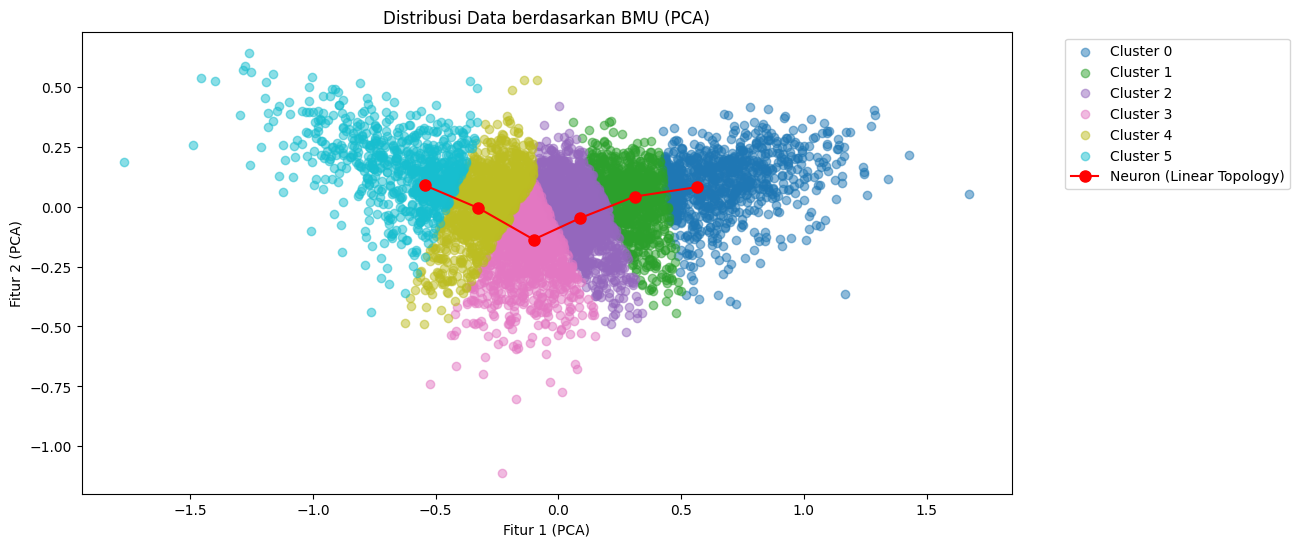

In [9]:
plot_cluster(X_pca, som_pca, weights_pca)

### Evaluasi Sebelum Tuning

In [10]:
def qete(som, data):
    qe = som.quantization_error(data)
    te = som.topographic_error(data)

    return print("Quantization Error (QE):", qe, "\nTopographic Error (TE)", te)

In [11]:
qete(som_pca, X_pca)

Quantization Error (QE): 0.16772429166014619 
Topographic Error (TE) 0.009547383309759547


In [12]:
def silhouette(som, data):
    bmu_indices = [som.hitung_bmu(x) for x in data]

    cluster_labels = np.array(bmu_indices)

    silhouette_avg = silhouette_score(data, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg:.4f}")

In [13]:
silhouette(som_pca, X_pca)

Silhouette Score: 0.2744


### Evaluasi Setelah Tuning

In [14]:
X_train_optuna = X_pca

m = 6
fitur = X_train_optuna.shape[1]  
R = 3.444946914492631
alpha0 = 0.03779439903621734
tau = 1092
n_iterations = 1392

som_optuna = SOMlinier(m=m, fitur=fitur, R=R, alpha=alpha0, tau=tau)

som_optuna.train(X_train_optuna, n_iterations)

weights_optuna = som_optuna.w
print("Trained SOM weights:", weights_optuna)

Trained SOM weights: [[ 0.56803433  0.07259611]
 [ 0.34834314  0.0180358 ]
 [ 0.07699934 -0.05675749]
 [-0.07462479 -0.05794297]
 [-0.30130581  0.00138898]
 [-0.48213829  0.0813207 ]]


C:\Users\lmaos\AppData\Local\Temp\ipykernel_3692\166035939.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_bmu_indices_pca))


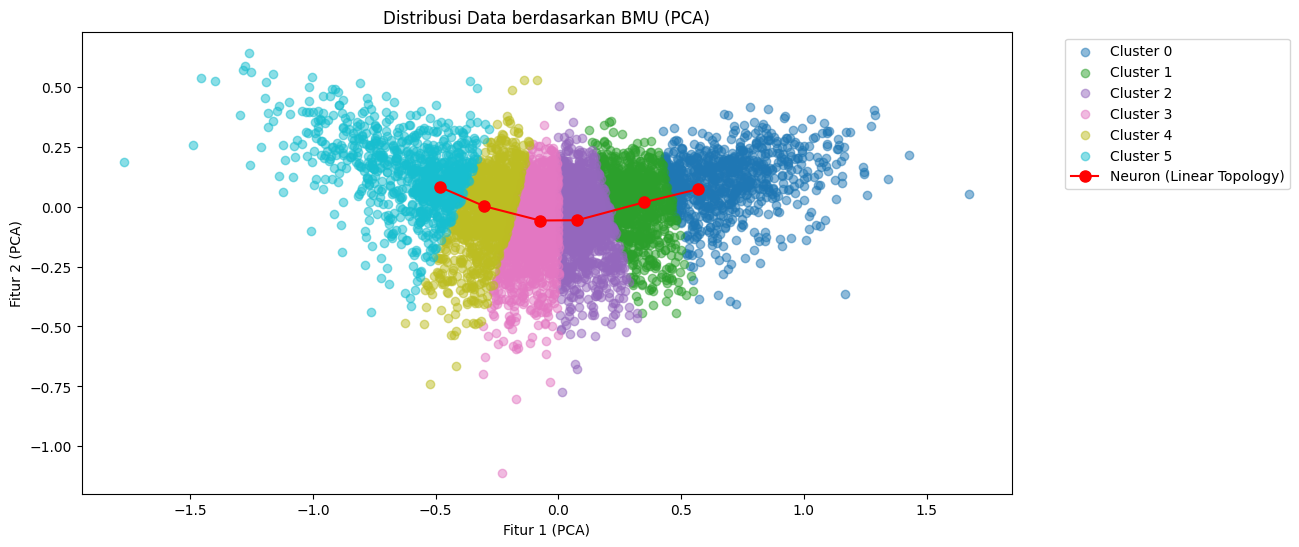

In [15]:
plot_cluster(X_train_optuna, som_optuna, weights_optuna)

In [16]:
qete(som_optuna, X_train_optuna)

Quantization Error (QE): 0.17254755032555408 
Topographic Error (TE) 0.0


In [17]:
silhouette(som_optuna, X_train_optuna)

Silhouette Score: 0.2445


### Analisis Lebih Lanjut

In [18]:
bmu_indices_pca = [som_optuna.hitung_bmu(x) for x in X_train_optuna]
unique_clusters, counts = np.unique(bmu_indices_pca, return_counts=True)
print("Distribusi data di setiap cluster:")
for cluster, count in zip(unique_clusters, counts):
    print(f"Cluster {cluster}: {count} data")


Distribusi data di setiap cluster:
Cluster 0: 787 data
Cluster 1: 817 data
Cluster 2: 1059 data
Cluster 3: 1180 data
Cluster 4: 965 data
Cluster 5: 848 data


Silhouette Score for K-Means clustering on SOM: 0.3867771039933062


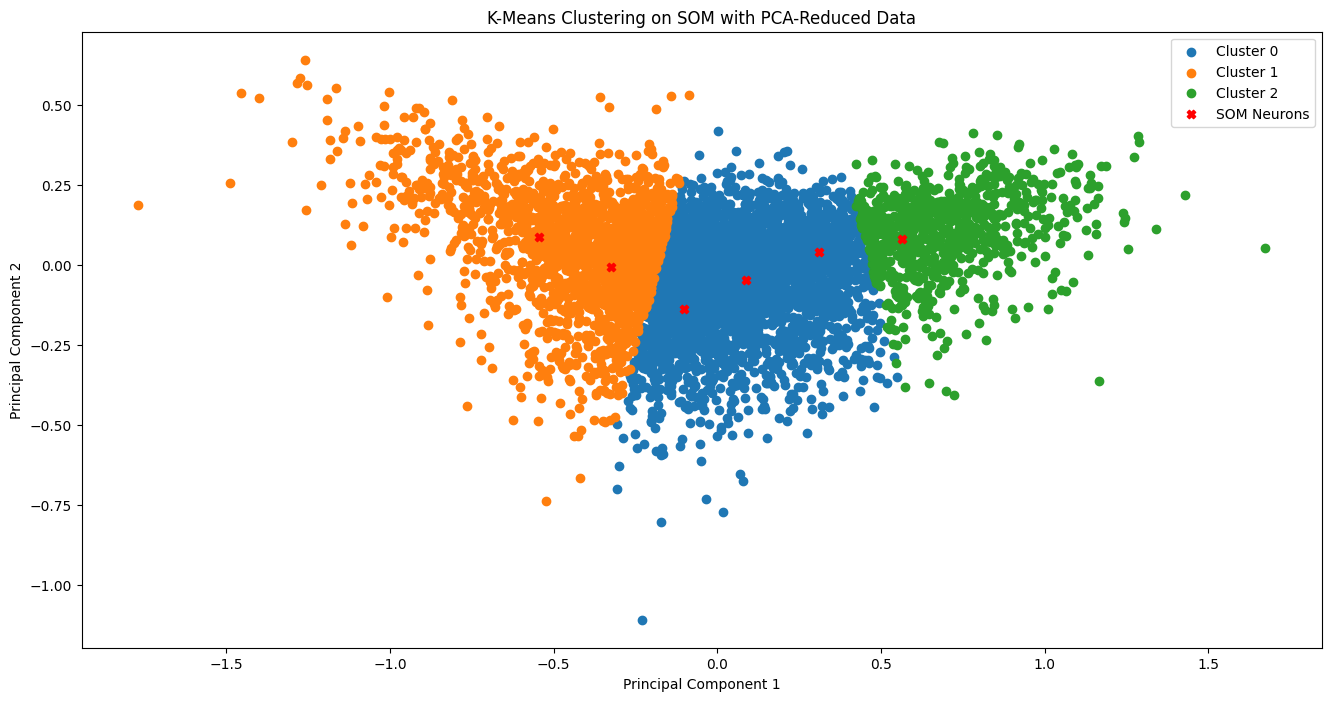

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

num_clusters = 3  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(weights_pca)

neuron_clusters = kmeans.labels_

data_clusters = np.array([neuron_clusters[som_optuna.hitung_bmu(x)] for x in X_train_optuna])


silhouette_avg = silhouette_score(X_train_optuna, data_clusters)
print("Silhouette Score for K-Means clustering on SOM:", silhouette_avg)

plt.figure(figsize=(16, 8))
for cluster in range(num_clusters):
    cluster_points = X_train_optuna[data_clusters == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')

plt.scatter(weights_pca[:, 0], weights_pca[:, 1], c='red', label='SOM Neurons', marker='X')

plt.title('K-Means Clustering on SOM with PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


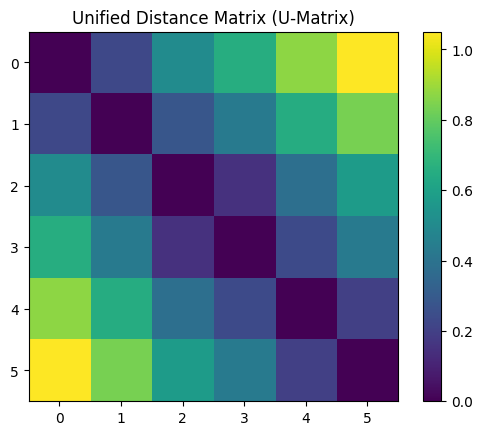

In [20]:
from scipy.spatial.distance import cdist

u_matrix = cdist(weights_optuna, weights_optuna)
plt.imshow(u_matrix, cmap='viridis')
plt.title("Unified Distance Matrix (U-Matrix)")
plt.colorbar()
plt.show()


In [21]:
def calculate_qe_per_data(som, data):
    qe_per_data = []
    for x in data:
        bmu_index = som.hitung_bmu(x)
        qe = np.linalg.norm(x - som.w[bmu_index])
        qe_per_data.append(qe)
    return np.array(qe_per_data)

qe_per_data = calculate_qe_per_data(som_pca, X_pca)

threshold = np.percentile(qe_per_data, 95) 
outliers = X_pca[qe_per_data > threshold]

print(f"Jumlah Outlier: {len(outliers)}")


Jumlah Outlier: 283


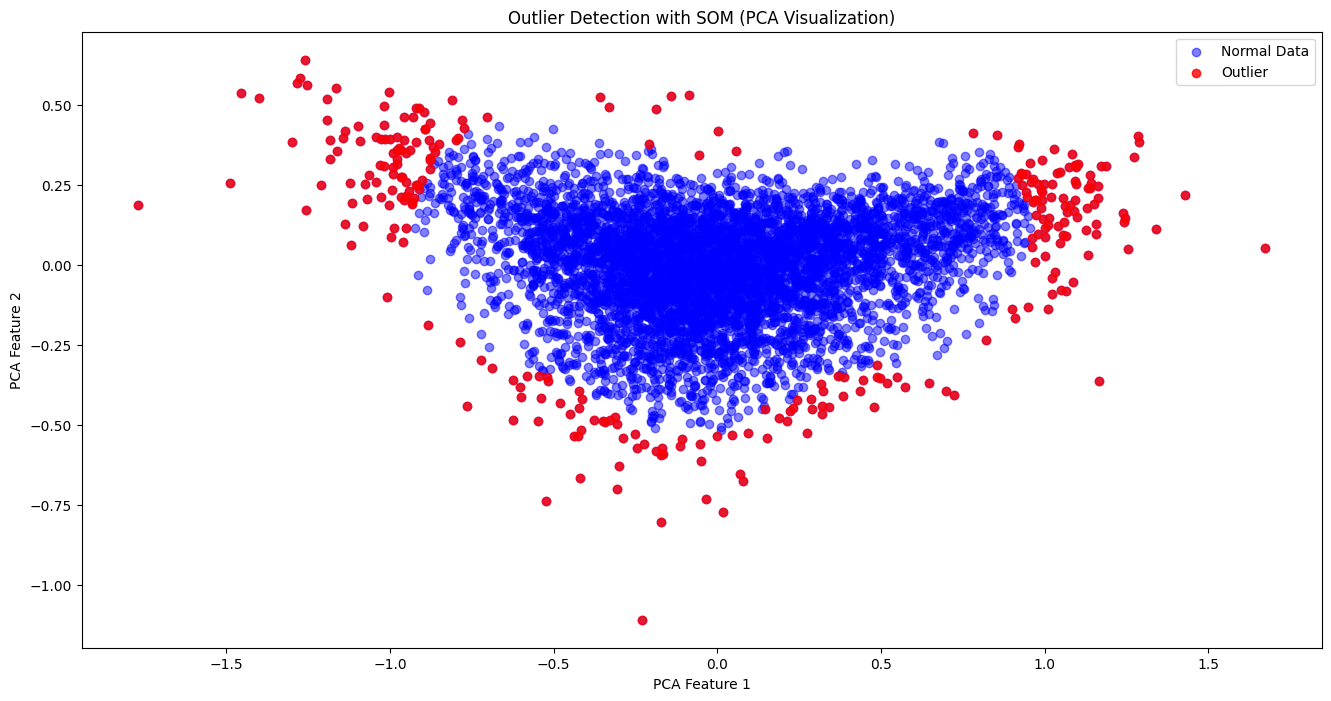

In [22]:
plt.figure(figsize=(16, 8))
plt.scatter(X_pca[:, 0], X_train_optuna[:, 1], c='blue', label="Normal Data", alpha=0.5)
plt.scatter(X_pca[qe_per_data > threshold, 0], X_pca[qe_per_data > threshold, 1], c='red', label="Outlier", alpha=0.8)
plt.legend()
plt.title("Outlier Detection with SOM (PCA Visualization)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.show()


In [23]:
def profil_kluster(som, data):
    kluster = [som.hitung_bmu(x) for x in data]
    df = pd.DataFrame(data)
    df['kluster'] = kluster
    
    profil = df.groupby('kluster').agg(['mean', 'std', 'min', 'max'])
    return profil

profil_kluster_result = profil_kluster(som_optuna, X_train_optuna)
print("Profil Kluster:\n", profil_kluster_result)

Profil Kluster:
                 0                                       1                      \
             mean       std       min       max      mean       std       min   
kluster                                                                         
0        0.698245  0.187511  0.423459  1.673926  0.104353  0.127313 -0.407037   
1        0.318988  0.077380  0.125694  0.550032  0.011439  0.140652 -0.444543   
2        0.103278  0.067026 -0.001039  0.319388 -0.069072  0.163480 -0.772533   
3       -0.102998  0.064167 -0.308067  0.001276 -0.094815  0.172489 -1.109975   
4       -0.288499  0.081491 -0.623830 -0.086048 -0.024583  0.166966 -0.738994   
5       -0.612695  0.201948 -1.769981 -0.281471  0.138302  0.156653 -0.440072   

                   
              max  
kluster            
0        0.413856  
1        0.357480  
2        0.417657  
3        0.342490  
4        0.530146  
5        0.641926  


In [24]:
from scipy import stats

def identifikasi_fitur_penting(som, data):
    kluster = [som.hitung_bmu(x) for x in data]
    df = pd.DataFrame(data)
    df['kluster'] = kluster
    
    fitur_penting = {}
    
    for i in range(data.shape[1]): 
        grup = [df[df['kluster'] == k].iloc[:, i] for k in range(som.m)]
        
        f_stat, p_value = stats.f_oneway(*grup)
        
        fitur_penting[f'Fitur {i}'] = {'F-statistic': f_stat, 'p-value': p_value}
    
    return fitur_penting


fitur_penting_result = identifikasi_fitur_penting(som_optuna, X_train_optuna)

for fitur, hasil in fitur_penting_result.items():
    print(f"{fitur}: F-statistic = {hasil['F-statistic']:.4f}, p-value = {hasil['p-value']:.4f}")

Fitur 0: F-statistic = 12096.5043, p-value = 0.0000
Fitur 1: F-statistic = 332.3107, p-value = 0.0000


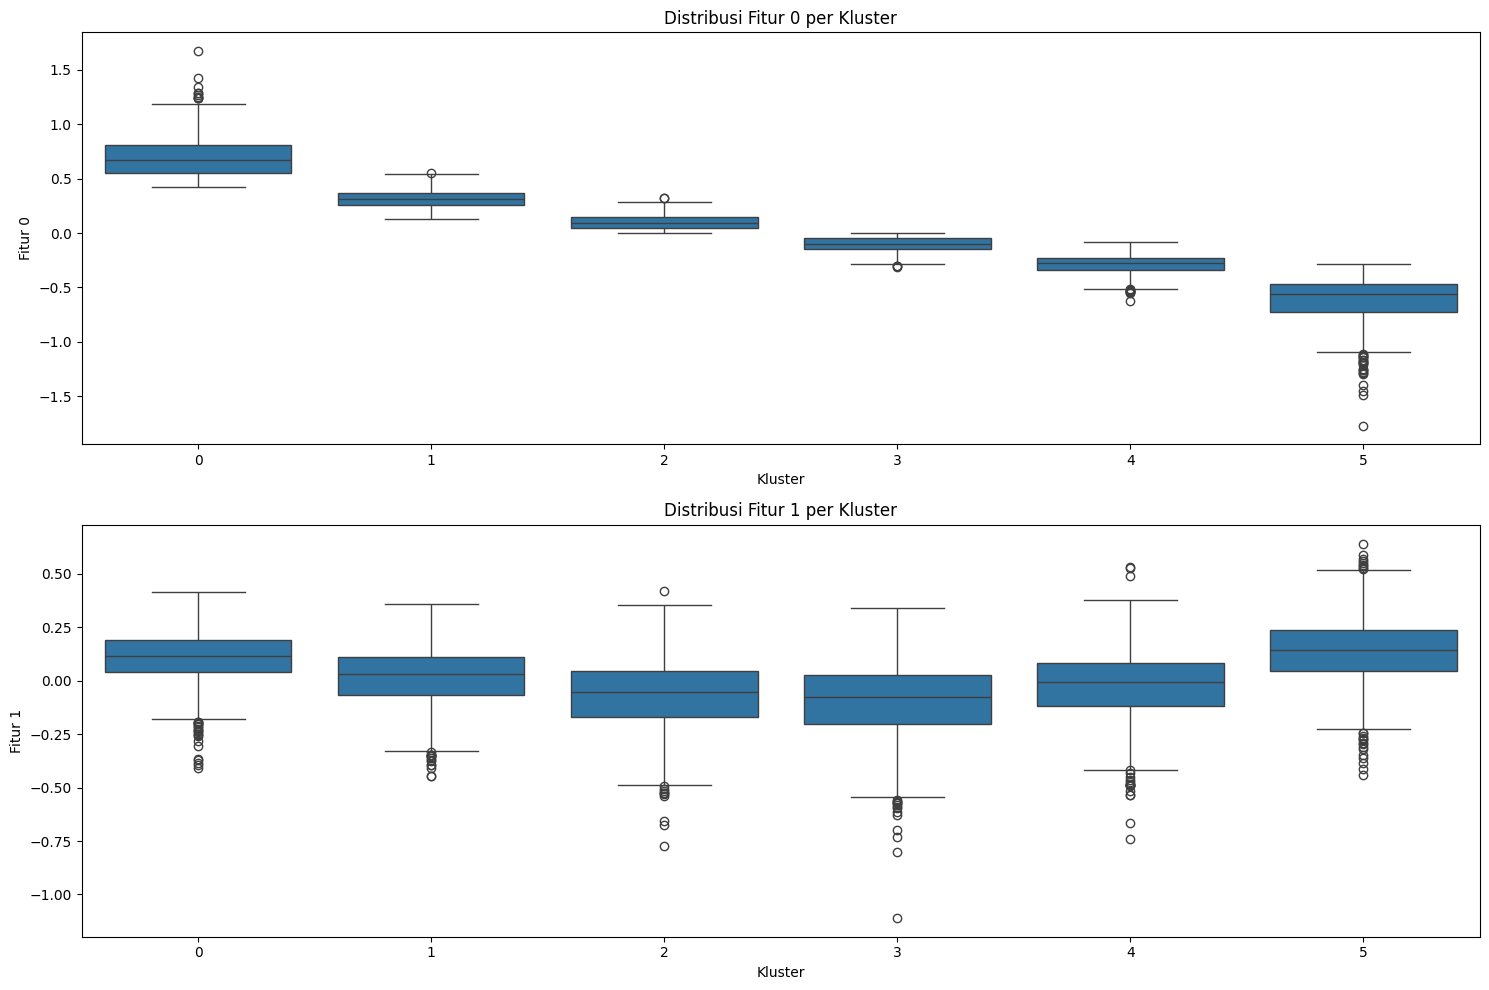

In [25]:
import seaborn as sns

def visualisasi_distribusi_fitur(som, data):
   
    kluster = [som.hitung_bmu(x) for x in data]
    df = pd.DataFrame(data)
    df['kluster'] = kluster
    
    plt.figure(figsize=(15, 10))
    
    for i in range(data.shape[1]):
        plt.subplot(2, (data.shape[1] + 1) // 2, i + 1)  
        sns.boxplot(x='kluster', y=df.columns[i], data=df)
        plt.title(f'Distribusi Fitur {i} per Kluster')
        plt.xlabel('Kluster')
        plt.ylabel(f'Fitur {i}')
    
    plt.tight_layout()
    plt.show()


visualisasi_distribusi_fitur(som_optuna, X_train_optuna)

In [ ]:

# weights_optuna = som_optuna.w  

# weights_somperf = weights_optuna.reshape(-1, fitur) 

# map_size = (m, 1)  
# topology_dist = rectangular_topology_dist(map_size)

# topographic_prod = topographic_product(topology_dist, weights_somperf)
# neighborhood_pres = neighborhood_preservation(1, weights_somperf, X_train_optuna)
# trustworthiness_score = trustworthiness(1, weights_somperf, X_train_optuna)

# print(f"Topographic Product = {topographic_prod}")
# print(f"Neighborhood Preservation = {neighborhood_pres}")
# print(f"Trustworthiness = {trustworthiness_score}")

TypeError: 'str' object cannot be interpreted as an integer

## Tuning

In [27]:
def objective(trial):
    m = trial.suggest_int('m', 2, 6) 
    R = trial.suggest_float('R', 0.1, 5.0)
    alpha0 = trial.suggest_float('alpha0', 0.01, 0.5) 
    tau = trial.suggest_int('tau', 100, 2000) 
    n_iterations = trial.suggest_int("n_iterations", 500, 1500)

    som_pca = SOMlinier(m=m, fitur=2, R=R, alpha=alpha0, tau=tau)
    som_pca.train(X_pca, n_iterations)

    qe = som_pca.quantization_error(X_pca)
    te = som_pca.topographic_error(X_pca)

    return qe + te

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best Parameters (Optuna):", study.best_params)
print("Best Score (QE + TE):", study.best_value)

[I 2024-11-20 19:48:35,622] A new study created in memory with name: no-name-7f9583a2-2141-4ac1-8919-c4eec8397279


[I 2024-11-20 19:48:35,731] Trial 0 finished with value: 0.31370132897919806 and parameters: {'m': 6, 'R': 2.282713774512179, 'alpha0': 0.29491759207295043, 'tau': 249, 'n_iterations': 984}. Best is trial 0 with value: 0.31370132897919806.
[I 2024-11-20 19:48:35,846] Trial 1 finished with value: 0.20844361389436047 and parameters: {'m': 6, 'R': 3.6945044336717627, 'alpha0': 0.39319087909621186, 'tau': 174, 'n_iterations': 878}. Best is trial 1 with value: 0.20844361389436047.
[I 2024-11-20 19:48:35,953] Trial 2 finished with value: 0.8194988282921771 and parameters: {'m': 5, 'R': 3.010881482566224, 'alpha0': 0.44634085699353204, 'tau': 692, 'n_iterations': 1338}. Best is trial 1 with value: 0.20844361389436047.
[I 2024-11-20 19:48:36,044] Trial 3 finished with value: 0.1949992689480875 and parameters: {'m': 4, 'R': 1.7435086938278954, 'alpha0': 0.3725878633707764, 'tau': 406, 'n_iterations': 605}. Best is trial 3 with value: 0.1949992689480875.
[I 2024-11-20 19:48:36,156] Trial 4 finis

Best Parameters (Optuna): {'m': 6, 'R': 3.444946914492631, 'alpha0': 0.03779439903621734, 'tau': 1092, 'n_iterations': 1392}
Best Score (QE + TE): 0.17223026437736005
